In [1]:
import numpy as np

import pandas as pd

from matplotlib import pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

## 1. Exploratory Data Analysis

Let's see first the number of matches data available and the number/names of the features of the dataset.

In [2]:
df = pd.read_csv('BWF-Data/ws.csv')

In [3]:
nm, nf = df.shape
print(f'Number of matches: {nm}. Number of features: {nf}')

Number of matches: 2975. Number of features: 38


In [4]:
df.T.iloc[:,0:4]

,0,1,2,3
tournament,PRINCESS SIRIVANNAVARI Thailand Masters 2018,PRINCESS SIRIVANNAVARI Thailand Masters 2018,PRINCESS SIRIVANNAVARI Thailand Masters 2018,PRINCESS SIRIVANNAVARI Thailand Masters 2018
city,Bangkok,Bangkok,Bangkok,Bangkok
country,Thailand,Thailand,Thailand,Thailand
date,09-01-2018,09-01-2018,09-01-2018,09-01-2018
tournament_type,HSBC BWF World Tour Super 300,HSBC BWF World Tour Super 300,HSBC BWF World Tour Super 300,HSBC BWF World Tour Super 300
discipline,WS,WS,WS,WS
round,Qualification quarter final,Qualification quarter final,Qualification quarter final,Qualification quarter final
winner,2,2,2,2
nb_sets,3,3,2,3
retired,False,False,False,False


### 1.1 Cleaning the data

While some of the detailed features above might arguably be useful for predicting the outcome of a match, we are going to discard most of them and just keep information about the names of the players, the date of the match and the total points scored by each. 

#### 1.1.1 Discarding unfinished games

let's first discard games in which one of the players retired, since that will not give us any information about the strength of each player, and in most cases it is probably due to an injury

In [5]:
df.retired.value_counts()

False    2933
True       42
Name: retired, dtype: int64

In [6]:
# let's get rid of the 42 matches where one player retired

df = df[df.retired == False]
del df['retired']

# let's reset the index, since rows were deleted
df.reset_index(inplace=True,drop=True)

#### 1.1.2 Keeping only essential features 

we now get rid of most features, except those relating to the players' identity, the date, the winner of the match and the points scored

In [7]:
features = ['date', 'team_one_players', 'team_two_players',
       'team_one_total_points', 'team_two_total_points', 'winner']

In [8]:
df = df[features]

In [9]:
df.iloc[:]

,date,team_one_players,team_two_players,team_one_total_points,team_two_total_points,winner
0,09-01-2018,Benyapa Aimsaard,Chasinee Korepap,51,57,2
1,09-01-2018,Krestina Silich,Nuntakarn Aimsaard,34,58,2
2,09-01-2018,Piramon Chamnaktan,Mattana Hemrachatanun,18,42,2
3,09-01-2018,Supanida Katethong,Manassanan Lerthattasin,54,59,2
4,10-01-2018,Nitchaon Jindapol,Nuntakarn Aimsaard,42,25,1
...,...,...,...,...,...,...
2928,26-03-2021,Iris Wang,Saina Nehwal,59,59,2
2929,26-03-2021,Ira Sharma,Line Christophersen,19,42,2
2930,27-03-2021,Saina Nehwal,Line Christophersen,34,42,2
2931,27-03-2021,Pornpawee Chochuwong,Busanan Ongbamrungphan,54,60,2


#### 1.1.3 Tidying up features' names and avoiding problems with players' names

+ First, let's change the players column names and the points columns. This will make the dataset easier to read

In [10]:
df.rename(columns={'team_one_players':'player1','team_two_players':'player2'},inplace=True)

In [11]:
df.rename(columns={'team_one_total_points':'points1','team_two_total_points':'points2'},inplace=True)

+ Second, we can see that some players appear as different names due to lowercase/uppercase differences, so let's homogeneize their names to avoid repeated player names

In [12]:
# some players have different name entries, for example, see Ratchanok Intanon below

df.player1.value_counts()

Tzu Ying Tai           101
Carolina Marin          68
Nozomi Okuhara          66
Ratchanok Intanon       61
Michelle Li             59
                      ... 
Chisato Hoshi            1
Jekaterina Romanova      1
Liana Lencevica          1
Ratchanok INTANON        1
Daniela Macias           1
Name: player1, Length: 357, dtype: int64

In [13]:
# putting names in lower case and replacing ' ' with '_' groups player entries 
# (for example: Tzu Ying Tai, Nozomi Okuhara, Ratachanok Intanon)

df.player1.str.lower().str.replace(' ','_').value_counts()

tzu_ying_tai             103
nozomi_okuhara            68
carolina_marin            68
ratchanok_intanon         62
michelle_li               59
                        ... 
marsa_indah_salsabila      1
li_ting_peng               1
yen_chi_kuo                1
getter_saar                1
daniela_macias             1
Name: player1, Length: 350, dtype: int64

In [14]:
df.player1 = df.player1.str.lower().str.replace(' ','_')
df.player2 = df.player2.str.lower().str.replace(' ','_')

In [15]:
df.iloc[:]

,date,player1,player2,points1,points2,winner
0,09-01-2018,benyapa_aimsaard,chasinee_korepap,51,57,2
1,09-01-2018,krestina_silich,nuntakarn_aimsaard,34,58,2
2,09-01-2018,piramon_chamnaktan,mattana_hemrachatanun,18,42,2
3,09-01-2018,supanida_katethong,manassanan_lerthattasin,54,59,2
4,10-01-2018,nitchaon_jindapol,nuntakarn_aimsaard,42,25,1
...,...,...,...,...,...,...
2928,26-03-2021,iris_wang,saina_nehwal,59,59,2
2929,26-03-2021,ira_sharma,line_christophersen,19,42,2
2930,27-03-2021,saina_nehwal,line_christophersen,34,42,2
2931,27-03-2021,pornpawee_chochuwong,busanan_ongbamrungphan,54,60,2


## 2. Feature engineering

The data now is much cleaner, and we have some features that should be really important to understand the strength of each player, basically who won each match, by how many points and when was the match. But now we should transform that information in a way that it will be useful to train a machine learning model.

### 2.1 Transforming "date" to "age"

As it is, the column "date" would be difficult to parse, so rather than a 'date', let's transform it into 'age', which will encode the number of days up to January 1st, 2022 (so older matches will have a larger 'age'). [The idea behind this is that more recent games should probably have a larger weight in predicting the outcome of future games] 

In [16]:
# let's add column age

date_format = "%d-%m-%Y"
a = datetime.strptime('01-01-2022', date_format)

df['age'] = [(a - datetime.strptime(date, date_format)).days for date in df.date]

In [17]:
# let's verify 'age' is fine (older games should have larger 'age')

df[['date','age']].tail()

,date,age
2928,26-03-2021,281
2929,26-03-2021,281
2930,27-03-2021,280
2931,27-03-2021,280
2932,28-03-2021,279


In [18]:
# we can now delete 'date'

del df['date']

The data now looks much nicer and tidy

In [19]:
df.iloc[:]

,player1,player2,points1,points2,winner,age
0,benyapa_aimsaard,chasinee_korepap,51,57,2,1453
1,krestina_silich,nuntakarn_aimsaard,34,58,2,1453
2,piramon_chamnaktan,mattana_hemrachatanun,18,42,2,1453
3,supanida_katethong,manassanan_lerthattasin,54,59,2,1453
4,nitchaon_jindapol,nuntakarn_aimsaard,42,25,1,1452
...,...,...,...,...,...,...
2928,iris_wang,saina_nehwal,59,59,2,281
2929,ira_sharma,line_christophersen,19,42,2,281
2930,saina_nehwal,line_christophersen,34,42,2,280
2931,pornpawee_chochuwong,busanan_ongbamrungphan,54,60,2,280


### 2.2 Calculating player strength columns

This dataset is very different from the ones we have used in the course so far, because each row contains information only about a particular match, and in order to predict the outcome of a future match, we need some information about the global strength of each player, so we somehow have to integrate all the information about each player into one or several features.

#### 2.2.1 ELO rating

A common measure of a player's strength used in chess is the ELO rating (see https://en.wikipedia.org/wiki/Elo_rating_system), which we are going to include in our dataset.

In [20]:
"""
Given ratings RA and RB, returns EA and EB 
  (expected probability of winning of player A and B, respectively) 
"""
def expected(ra,rb):
    ea = 1 / (1 + 10**((rb-ra)/400))
    eb = 1 / (1 + 10**((ra-rb)/400))
    return (ea,eb)

"""
Input: 
  RA, RB: ratings for players
  SA, SB: score of players (0: lose, 1 win)
  K     : ELO constant (the bigger, the larger movement of scores for each game)
            10 was proposed originally by Elo, 24 is used nowadays
Output:
  RA_n, RB_n: the new ratings for both players
"""
def scores(ra,rb,sa,sb,k=24):
    (ea,eb) = expected(ra,rb)
    ra_n = ra + k * (sa - ea)
    rb_n = rb + k * (sb - eb)
    return (ra_n,rb_n)

We can see how ELO ratings work with the following example. If we have two players with the same ELO rating (e.g. 1500), and the first one wins, the new scores will be (1512,1488).

In [21]:
scores(1500,1500,1,0)

(1512.0, 1488.0)

If a strong player (ELO: 1900), plays a weaker player (ELO: 1400), we expect the first player to win. If this is the case, the points that the strong player wins (and which the weaker player loses) are only 1.3.

In [22]:
scores(1900,1400,1,0)

(1901.2777651648485, 1398.7222348351515)

If the same two players play, but the winner is the weaker player, then the weaker player gets (and the stronger player loses) 22.7 points). 

In [23]:
scores(1900,1400,0,1)

(1877.2777651648485, 1422.7222348351515)

#### 2.2.2 Adding ELO rating to our data

+ First, we need a list of all players 

In [24]:
p1 = df.player1.unique()
p2 = df.player2.unique()
all_players = np.unique(np.concatenate((p1,p2)))

"""
Given a player, return its index in the 'all_players' list
"""
def find_iloc(player):
    return np.where(all_players == player)[0][0]

+ Second, we consider all matches and update the ratings for all players according to the ELO formula above and their initial ratings (all 1500)

In [25]:
ratings = np.full((len(all_players)),1500)

for i in range(df.age.shape[0]):
    p1i = find_iloc(df.player1[i])
    p2i = find_iloc(df.player2[i])
    r1 = ratings[p1i]
    r2 = ratings[p2i]
    if df.points1[i] > df.points2[i]:
        s1 = 1 
        s2 = 0
    else:
        s1 = 0
        s2 = 1
        
    r1n,r2n = scores(r1,r2,s1,s2)
    ratings[p1i] = r1n
    ratings[p2i] = r2n        

+ Third, let's add ELO ratings for each player for each match

In [26]:
elo1 = [0] * df.age.shape[0]
elo2 = [0] * df.age.shape[0]

for i in range(df.age.shape[0]):
    p1i = find_iloc(df.player1[i])
    p2i = find_iloc(df.player2[i])
    elo1[i] = ratings[p1i]
    elo2[i] = ratings[p2i]

df["elo1"] = elo1
df["elo2"] = elo2

We now have ELO data (calculated based on all matches data available) for each player.

In [27]:
df.iloc[:]

,player1,player2,points1,points2,winner,age,elo1,elo2
0,benyapa_aimsaard,chasinee_korepap,51,57,2,1453,1479,1499
1,krestina_silich,nuntakarn_aimsaard,34,58,2,1453,1488,1426
2,piramon_chamnaktan,mattana_hemrachatanun,18,42,2,1453,1488,1487
3,supanida_katethong,manassanan_lerthattasin,54,59,2,1453,1553,1508
4,nitchaon_jindapol,nuntakarn_aimsaard,42,25,1,1452,1531,1426
...,...,...,...,...,...,...,...,...
2928,iris_wang,saina_nehwal,59,59,2,281,1521,1542
2929,ira_sharma,line_christophersen,19,42,2,281,1479,1572
2930,saina_nehwal,line_christophersen,34,42,2,280,1542,1572
2931,pornpawee_chochuwong,busanan_ongbamrungphan,54,60,2,280,1650,1627


#### 2.2.3 Adding ELO gradient 

Although not usually taken into account, we can also calculate an ELO gradient for each match (i.e. a measure of whether when that match happened the ELO progression for that player was increasing or decreasing).

As an example, in the case of player "Joy Xuan Deng", we can see an increase in her ELO rating for the first half of the matches, while a quick decrease in the second half. This information could probably be relevant to make better predictions.

In [28]:
"""
Calculate the ELO ratings throughout the period covered by the dataset
 for a given player.

Output: list of ELO ratings, ordered by age (first in the list is the oldest)
"""
def rating_progress(player):
    rating_player = np.full(df.age.shape[0],0)
    rating_player[0] = 1500
    ratings = np.full((len(all_players)),1500)

    for i in range(df.age.shape[0]):
        p1i = find_iloc(df.player1[i])
        p2i = find_iloc(df.player2[i])
        r1 = ratings[p1i]
        r2 = ratings[p2i]
        if df.points1[i] > df.points2[i]:
            s1 = 1 
            s2 = 0
        else:
            s1 = 0
            s2 = 1

        r1n,r2n = scores(r1,r2,s1,s2)
        ratings[p1i] = r1n
        ratings[p2i] = r2n        
        if df.player1[i] == player:
            rating_player[i] = r1n
        elif df.player2[i] == player:
            rating_player[i] = r2n
        else:
            if i > 0:
                rating_player[i] = rating_player[i-1]
    
    return rating_player

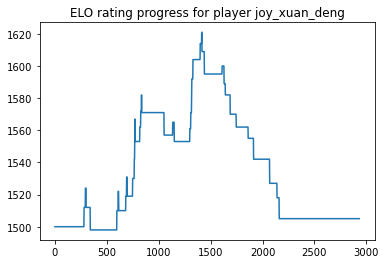

In [29]:
player_rating_progress = rating_progress("joy_xuan_deng")

plt.title(f'ELO rating progress for player joy_xuan_deng')
plt.plot(player_rating_progress)

So, let's calculate for each match, the ELO gradient for each player

In [30]:
ratings  = np.full((len(all_players)),1500.)
delta    = np.full((len(all_players)),0.)    # for each match we store the change in the ELO rating
gradient = np.full((len(all_players)),0.)    # the change in the previous match is the gradient to take into
                                             #    consideration for the current match
df["grad1"] = [0] * df.age.shape[0]
df["grad2"] = [0] * df.age.shape[0]

for i in range(df.age.shape[0]):
    p1i = find_iloc(df.player1[i])
    p2i = find_iloc(df.player2[i])
    r1 = ratings[p1i]
    r2 = ratings[p2i]
    if df.points1[i] > df.points2[i]:
        s1 = 1 
        s2 = 0
    else:
        s1 = 0
        s2 = 1
        
    r1n,r2n = scores(r1,r2,s1,s2)
    ratings[p1i] = r1n
    ratings[p2i] = r2n        

    if i > 0:
        gradient[p1i] = delta[p1i]
        gradient[p2i] = delta[p2i]
        df.grad1[i] = gradient[p1i] 
        df.grad2[i] = gradient[p2i] 
        
    delta[p1i] = r1n - r1
    delta[p2i] = r2n - r2

<ipython-input-30-977609a9a123>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.grad1[i] = gradient[p1i]
<ipython-input-30-977609a9a123>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.grad2[i] = gradient[p2i]


We can now see the ELO gradients for player "Joy Xuan Deng", which started off quite well, but in the latest matches were always negative.

In [31]:
player="joy_xuan_deng"
gradients_player = np.full(df.age.shape[0],0)

for i in range(df.age.shape[0]):
    if df.player1[i] == player:
        gradients_player[i] = df.grad1[i]
    elif df.player2[i] == player:
        gradients_player[i] = df.grad2[i]
    else:
        if i > 0:
            gradients_player[i] = gradients_player[i-1]            

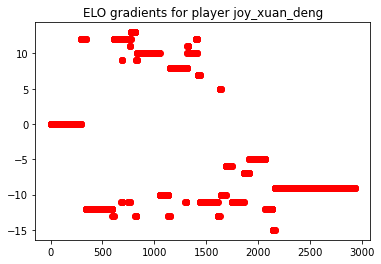

In [32]:
plt.title(f'ELO gradients for player joy_xuan_deng')
plt.plot(gradients_player,'ro')

Other features could probably be calculated to better inform the model (for example, personalized ELOs, i.e. ELO rating but only for matches between the players under consideration, etc.), but for the current project this is probably enough. 

The final dataset then looks like the following:

In [33]:
df

,player1,player2,points1,points2,winner,age,elo1,elo2,grad1,grad2
0,benyapa_aimsaard,chasinee_korepap,51,57,2,1453,1479,1499,0.000000,0.000000
1,krestina_silich,nuntakarn_aimsaard,34,58,2,1453,1488,1426,0.000000,0.000000
2,piramon_chamnaktan,mattana_hemrachatanun,18,42,2,1453,1488,1487,0.000000,0.000000
3,supanida_katethong,manassanan_lerthattasin,54,59,2,1453,1553,1508,0.000000,0.000000
4,nitchaon_jindapol,nuntakarn_aimsaard,42,25,1,1452,1531,1426,0.000000,12.000000
...,...,...,...,...,...,...,...,...,...,...
2928,iris_wang,saina_nehwal,59,59,2,281,1521,1542,10.582417,11.824876
2929,ira_sharma,line_christophersen,19,42,2,281,1479,1572,11.118792,7.333730
2930,saina_nehwal,line_christophersen,34,42,2,280,1542,1572,11.268377,9.082124
2931,pornpawee_chochuwong,busanan_ongbamrungphan,54,60,2,280,1650,1627,8.337433,8.851760


## 3. Model training

### 3.1 Validation framework 

We will split the data in three set: *train*, *val* and *test* (60%, 20% and 20% of the data, respectively).

*train_full* will be used in the last stage, to train the model with 80% of the data. 

The target variable is **winner**, and for the training data (**X_train**, **X_val**, etc.) we remove the names of the players and the number of points obtained in a match, since that only affects a particular match, and they do not represent a player's playing strength, which is the information that the model can use to predict a future match.

In [34]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

# We create a copy of df_train_full, because we will need to keep all the columns for later processing
df_train_full_base = df_train_full.copy()

y_train_full = df_train_full.winner.to_numpy()
y_train = df_train.winner.to_numpy()
y_val = df_val.winner.to_numpy()
y_test = df_test.winner.to_numpy()

del df_train_full['player1']
del df_train['player1']
del df_val['player1']
del df_test['player1']

del df_train_full['player2']
del df_train['player2']
del df_val['player2']
del df_test['player2']

del df_train_full['points1']
del df_train['points1']
del df_val['points1']
del df_test['points1']

del df_train_full['points2']
del df_train['points2']
del df_val['points2']
del df_test['points2']

del df_train_full['winner']
del df_train['winner']
del df_val['winner']
del df_test['winner']

X_train_full = df_train_full.to_numpy()
X_train = df_train.to_numpy()
X_val  = df_val.to_numpy()
X_test  = df_test.to_numpy()

### 3.2 Logistic Regression

Training a logistic regression model and getting winner predictions is trivial using Scikit-learn package

In [35]:
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

#### 3.2.1 Baseline model performance

+ Let's first look at the **confusion matrix**, which shows us that when the winner is the first player, the model predicts this in most cases (251), but it predicts the second player as winner in 61 cases. We have similar values for the cases when the winner is player 2. In this case, the model fails to predict this in 87 cases, but it predicts player 2 as correct in 188 cases.

In [36]:
confusion_matrix(y_val, y_pred)

array([[251,  61],
       [ 87, 188]])

+ A good metric in this case is **acuracy_score**, which will give us the percentage of cases when the model was able to predict correctly the winner.

In [37]:
acc_score = accuracy_score(y_pred, y_val)
print('Accuracy score = %.3f' % acc_score)

Accuracy score = 0.748


+ We see that in this case the **roc_auc_score** gives a very similar value, and that the **ROC curve** has a more or less common pattern, though I think in this case **acuracy_score** is more intuitive, so from now on I will use it to measure the performance of the next models.

In [38]:
auc = roc_auc_score(y_val, y_pred)
print('AUC = %.3f' % auc)

AUC = 0.744


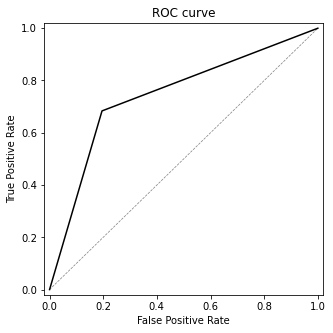

In [39]:
fpr, tpr, thresholds = roc_curve(y_val -1 , y_pred -1)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

#### 3.2.2 Can we improve performance by using different regularization parameters?

We will test this while also using **KFold** for cross-validation. As we can see, the *standard deviation* between different sets provided by *KFold* is very small. On the other hand, for this particular model, the regularization parameter seems to have no influence whatsoever, obtaining in all cases a mean accuracy score of 0.74.

In [40]:
for C in [0.01, 0.1, 1, 10]:

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    accuracy_scores = []    
    
    for train_idx, val_idx in kfold.split(df_train_full):
        df_t = df_train_full.iloc[train_idx]
        df_v = df_train_full.iloc[val_idx]

        y_t = df_train_full_base.winner.iloc[train_idx].to_numpy()
        y_v   = df_train_full_base.winner.iloc[val_idx].to_numpy()

        X_t = df_t.to_numpy()
        X_v = df_v.to_numpy()

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
        model.fit(X_t, y_t)

        y_p = model.predict(X_v)

        acc_score = accuracy_score(y_p, y_v)
        accuracy_scores.append(acc_score)
        
    print('C=%s %.3f +- %.3f' % (C, np.mean(accuracy_scores), np.std(accuracy_scores)))

C=0.01 0.736 +- 0.010
C=0.1 0.736 +- 0.010
C=1 0.736 +- 0.010
C=10 0.736 +- 0.010


### 3.3 Decision Trees

We use here the **DecisionTreeClassifier**, useful for classification cases when our target variable is of type *integer*.

When used with the default parameters, we see that the accuracy of the model is worse than for the LinearRegression model.

In [41]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)
print(f"Accuracy Decision tree model (default parameters): {round(accuracy_score(y_pred,y_val),3)}")

Accuracy Decision tree model (default parameters): 0.663


We have to analyze if this poor performance is due to overfitting (when the accuracy for the training set is perfect, but much worse for the validation set). As we see below, this is indeed the case.

In [42]:
y_pred = dt.predict(X_train)
print(f"Accuracy of training set: {round(accuracy_score(y_pred,y_train),3)}")

y_pred = dt.predict(X_val)
print(f"Accuracy of validation set: {round(accuracy_score(y_pred,y_val),3)}")

Accuracy of training set: 1.0
Accuracy of validation set: 0.663


Thus, we have to tune the parameters for the decisioin trees, and we will follow what we did during the lessons, tuning the *maximum depth* of the tree, and the *min_samples_leaf*. We see that the best option is a *depth* of 4 and 20 *min_samples_leaf*, giving us an accuracy score of ~0.74, basically the same as the *Logistic Regression* model.

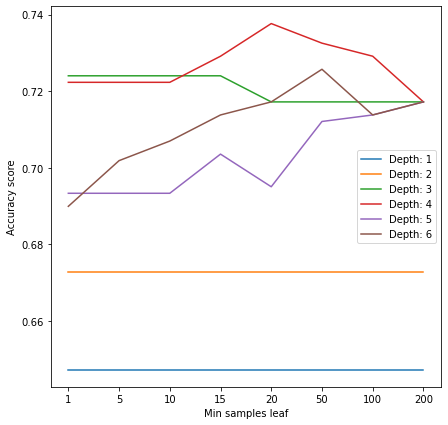

In [43]:
plt.figure(figsize=(7,7))

for m in [1,2,3,4, 5, 6]:
    accuracies = []
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s,random_state=42)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        acc_s = accuracy_score(y_val, y_pred)
        accuracies.append(acc_s)
#        print('%s -> %.3f' % (s, acc_s))
    plt.plot(accuracies,label=f"Depth: {m}")

plt.xlabel('Min samples leaf')
plt.ylabel('Accuracy score')    
plt.xticks([0,1,2,3,4,5,6,7],["1","5","10","15","20","50","100","200"])   
plt.legend()
    

### 3.4 Random Forest

We use here the **RandomForestClassifier**, useful for classification cases when our target variable is of type *integer*.

When used with the default parameters, we see that the accuracy of the model is basically the same (~0.74) as the one obtained with the Logistic Regression or the Decision Tree models.

In [44]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print(f"Accuracy Random Forest model (default parameters): {round(accuracy_score(y_pred,y_val),3)}")

Accuracy Random Forest model (default parameters): 0.738


Let's see now if we can improve the accuracy of the model by tuning the *number of estimators (trees)*, *depth* of the trees, and the *min_samples_leaf* parameters.

+ First, fixing the *depth* and *min_samples_leaf* to the best values we found for the "Decision Tree" model, we can vary the number of trees, and we see that the best accuracy is obtained with 110 trees (though the differences are quite small anyway) 

10 -> 0.731
20 -> 0.756
30 -> 0.768
40 -> 0.773
50 -> 0.767
60 -> 0.765
70 -> 0.768
80 -> 0.772
90 -> 0.775
100 -> 0.773
110 -> 0.777
120 -> 0.772
130 -> 0.765
140 -> 0.770
150 -> 0.772
160 -> 0.773
170 -> 0.775
180 -> 0.773
190 -> 0.773
200 -> 0.773


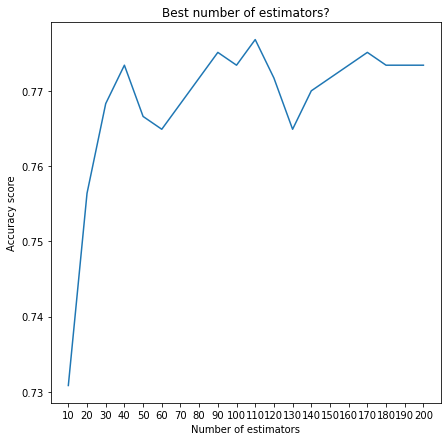

In [45]:
plt.figure(figsize=(7,7))

acc_scores = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, max_depth=4, min_samples_leaf= 20, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print('%s -> %.3f' % (i, acc))
    acc_scores.append(acc)
    
plt.plot(acc_scores)    

xs = list(range(0,20))
xstr = [str(x) for x in list(range(10,201,10))]

plt.title("Best number of estimators?")
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)   
plt.show()

+ We can now see if modifying the *max_depth* after fixing the number of estimators gives us a better accuracy. And indeed, we can see with a max_depth of 5, we manage to get an accuracy of 0.785

3 -> 0.741
4 -> 0.777
5 -> 0.785
6 -> 0.780
7 -> 0.777


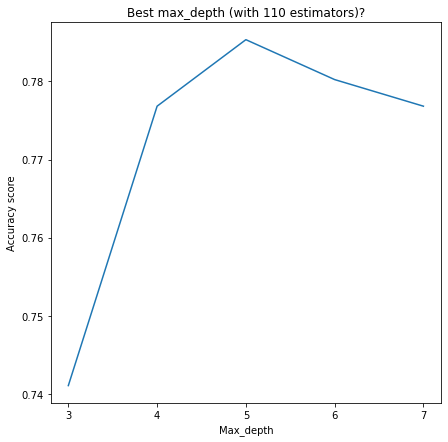

In [46]:
plt.figure(figsize=(7,7))

acc_scores = []

for i in range(3, 8):
    rf = RandomForestClassifier(n_estimators=110, max_depth=i, min_samples_leaf= 20, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print('%s -> %.3f' % (i, acc))
    acc_scores.append(acc)
    
plt.plot(acc_scores)    

xs = list(range(0,5))
xstr = [str(x) for x in list(range(3,8))]

plt.title("Best max_depth (with 110 estimators)?")
plt.xlabel('Max_depth')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)   
plt.show()

+ Lastly, we can see if modifying the *min_samples_leaf* after fixing the number of estimators and the maximum depth gives us a better accuracy. In this case, we see that the best accuracy remains with *min_sample_leaf == 20*

10 -> 0.770
20 -> 0.785
30 -> 0.770
40 -> 0.770
50 -> 0.763


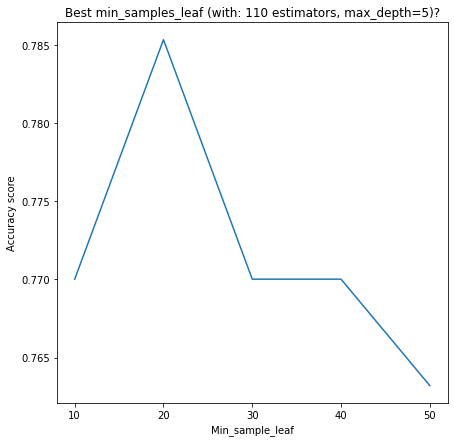

In [47]:
plt.figure(figsize=(7,7))

acc_scores = []

for i in range(10, 51, 10):
    rf = RandomForestClassifier(n_estimators=110, max_depth=5, min_samples_leaf= i, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print('%s -> %.3f' % (i, acc))
    acc_scores.append(acc)
    
plt.plot(acc_scores)    

xs = list(range(0,5))
xstr = [str(x) for x in list(range(10,51,10))]

plt.title("Best min_samples_leaf (with: 110 estimators, max_depth=5)?")
plt.xlabel('Min_sample_leaf')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)   
plt.show()

### 3.5 XGBoost

We use here the **xgboost**, with an objective of "binary:logistic", but this requires that our target values are between [0,1], when our winner information is either 1 or 2. We can subtract 1 from our data, and then we are able to use the 'binary:logistic' objective.

In [48]:
# subtract one, so that the values for the target variable will be 0|1

y_train_xg = y_train - 1
y_val_xg = y_val - 1

In [49]:
dtrain = xgb.DMatrix(X_train, label=y_train_xg, feature_names=df_train.columns)
dval = xgb.DMatrix(X_val, label=y_val_xg, feature_names=df_train.columns)

During the course we used a watchlist and the "AUC" eval metric to evaluate XGBoost, but since we have been using throughout the *accuracy_score*, we calculate and plot these values using a different (but equivalent) approach, calculating the *accuracy_score* for differnt Boost numbers. And as we can see below, from the detailed output, and from the plot, the best accuracy score (0.74) is obtained when *num_boost_round* is ~40, though still far from the 0.785 obtained with the Random Forest model.

In [50]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1
}

10 -> 0.734
20 -> 0.734
30 -> 0.734
40 -> 0.738
50 -> 0.731
60 -> 0.734
70 -> 0.729
80 -> 0.736
90 -> 0.727
100 -> 0.736


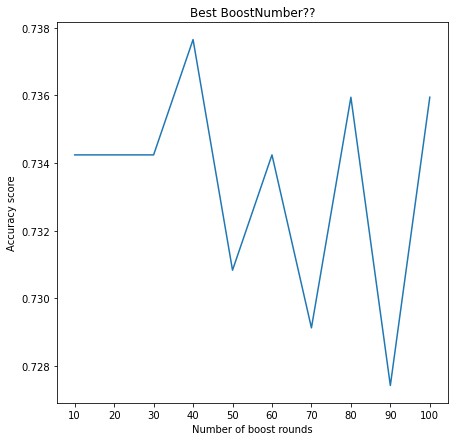

In [51]:
plt.figure(figsize=(7,7))

acc_scores = []

for i in range(10, 101,10):
    model = xgb.train(xgb_params, dtrain,
                  num_boost_round=i)
    y_pred_xg = model.predict(dval)

    # we add one and convert to integer, for easy comparison with y_val
    y_pred = np.rint(y_pred_xg + 1).astype(int)    
    acc = accuracy_score(y_val, y_pred)
    print('%s -> %.3f' % (i, acc))
    acc_scores.append(acc)
    
plt.plot(acc_scores)    

xs = list(range(0,10))
xstr = [str(x) for x in list(range(10,101,10))]

plt.title("Best BoostNumber??")
plt.xlabel('Number of boost rounds')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)   
plt.show()



So, as per the examples during the course, let's analyze the effect of varying **eta**, **max_depth**, and **min_child_weight**

+ Let's see first the effect of **eta** parameter. From the plot below it is not totally clear, but an **eta == 0.1** seems to be the best overall option, assuming a boost number ~100.

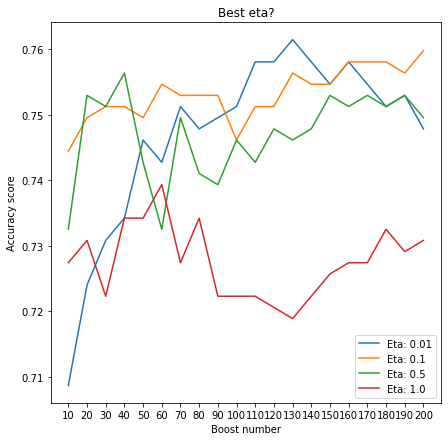

In [52]:
plt.figure(figsize=(7,7))

for m in [0.01,0.1,0.5,1.0]:
    xgb_params['eta'] = m
    accuracies = []

    for nb in range(10,201,10):
        model = xgb.train(xgb_params, dtrain,
                      num_boost_round=nb)
        y_pred_xg = model.predict(dval)

        # we add one and convert to integer, for easy comparison with y_val
        y_pred = np.rint(y_pred_xg + 1).astype(int)    
        acc = accuracy_score(y_val, y_pred)
#        print('%s -> %.3f' % (m, acc))
        accuracies.append(acc)

    plt.plot(accuracies,label=f"Eta: {m}")

xs = list(range(0,20))
xstr = [str(x) for x in range(10,201,10)]    
plt.title("Best eta?")
plt.xlabel('Boost number')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)
plt.legend()
plt.show()    

+ Let's see now the effect of **max_depth** parameter (after fixing **eta == 0.01**. From the plot below  **max_depth == 6** seems to be the best overall option, assuming a boost number ~100.

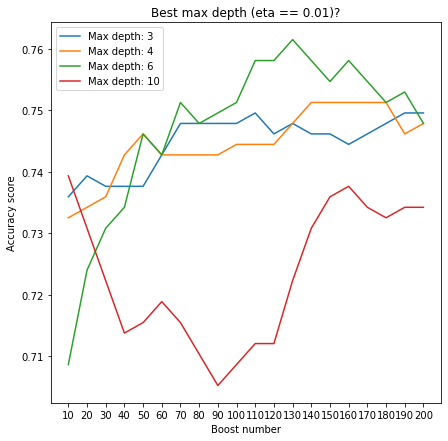

In [53]:
plt.figure(figsize=(7,7))

xgb_params['eta'] = 0.01

for m in [3,4,6,10]:
    xgb_params['max_depth'] = m

    accuracies = []

    for nb in range(10,201,10):
        model = xgb.train(xgb_params, dtrain,
                      num_boost_round=nb)
        y_pred_xg = model.predict(dval)

        # we add one and convert to integer, for easy comparison with y_val
        y_pred = np.rint(y_pred_xg + 1).astype(int)    
        acc = accuracy_score(y_val, y_pred)
     #   print('%s -> %.3f' % (m, acc))
        accuracies.append(acc)

    plt.plot(accuracies,label=f"Max depth: {m}")

xs = list(range(0,20))
xstr = [str(x) for x in range(10,201,10)]    
plt.title("Best max depth (eta == 0.01)?")
plt.xlabel('Boost number')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)
plt.legend()
plt.show()    

+ Let's finally see the effect of **min_child_weight** parameter (after fixing **eta == 0.01** and **max_depth == 6**. From the plot below  **min_child_weight == 1** seems to be the best overall option, assuming a boost number ~100.

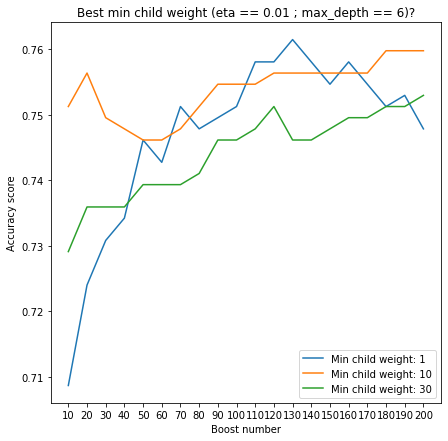

In [54]:
plt.figure(figsize=(7,7))

xgb_params['eta'] = 0.01
xgb_params['max_depth'] = 6

for m in [1,10,30]:
    xgb_params['min_child_weight'] = m

    accuracies = []

    for nb in range(10,201,10):
        model = xgb.train(xgb_params, dtrain,
                      num_boost_round=nb)
        y_pred_xg = model.predict(dval)

        # we add one and convert to integer, for easy comparison with y_val
        y_pred = np.rint(y_pred_xg + 1).astype(int)    
        acc = accuracy_score(y_val, y_pred)
     #   print('%s -> %.3f' % (m, acc))
        accuracies.append(acc)

    plt.plot(accuracies,label=f"Min child weight: {m}")

xs = list(range(0,20))
xstr = [str(x) for x in range(10,201,10)]    
plt.title("Best min child weight (eta == 0.01 ; max_depth == 6)?")
plt.xlabel('Boost number')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)
plt.legend()
plt.show()    

+ So, finally, for the parameters found above (**eta==0.01**, **max_depth==6**, and **min_child_weight**), let's find the best boost number. As we can see below, the best accuracy is obtained when Boost number is 130, with an accuracy score of 0.761.

10 -> 0.709
20 -> 0.724
30 -> 0.731
40 -> 0.734
50 -> 0.746
60 -> 0.743
70 -> 0.751
80 -> 0.748
90 -> 0.750
100 -> 0.751
110 -> 0.758
120 -> 0.758
130 -> 0.761
140 -> 0.758
150 -> 0.755
160 -> 0.758
170 -> 0.755
180 -> 0.751
190 -> 0.753
200 -> 0.748


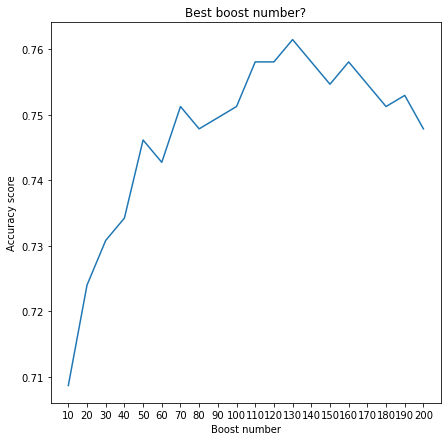

In [55]:
plt.figure(figsize=(7,7))

xgb_params['eta'] = 0.01
xgb_params['max_depth'] = 6
xgb_params['min_child_weight'] = 1

accuracies = []

for nb in range(10,201,10):
    model = xgb.train(xgb_params, dtrain,
                    num_boost_round=nb)
    y_pred_xg = model.predict(dval)

    # we add one and convert to integer, for easy comparison with y_val
    y_pred = np.rint(y_pred_xg + 1).astype(int)    
    acc = accuracy_score(y_val, y_pred)
    print('%s -> %.3f' % (nb, acc))
    accuracies.append(acc)

plt.plot(accuracies)

xs = list(range(0,20))
xstr = [str(x) for x in range(10,201,10)]    
plt.title("Best boost number?")
plt.xlabel('Boost number')
plt.ylabel('Accuracy score')    
plt.xticks(xs,xstr)
plt.show()    

### 3.6 Conclusion

After trying Logistic Regression, Decision Tree, Random Forest and XGBoost, and trying to tune each of them to obtain the best possible accuracy score, the winner overall was:

+ *Random Forest*, with the following parameter values: *estimators*: 110, *max_depth*: 5 and *min_sample_leaf*: 20, obtaining an *accuracy score* of 0.785. 

+ While an accuracy score of 0.785 might not look like very good, predicting winners at sport matches can be quite difficult. For example, a recent paper on the "Prediction of football match results with Machine Learning" (https://www.sciencedirect.com/science/article/pii/S1877050922007955) reports an accuracy of 65.26% for their best model (although football is arguably more difficult to predict than individual badminton matches).

### 3.7 Final testing 

Given the selection of the best model in the previous section, we can do our final testing, training with the full training data and testing on the testing data (as per the Validation Framework section above), and we see that the accuracy drops to ~75%, but it is not a very large drop, so it looks like the model is quite reliable for new data.

In [56]:
rf = RandomForestClassifier(n_estimators=110, max_depth=5, min_samples_leaf= 20, random_state=42)
rf.fit(X_train_full, y_train_full)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy score on final test data: -> %.3f' % (acc))


Accuracy score on final test data: -> 0.746
